In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data import *
from agent import SupplyChain

from ql import q_learning
import plotting
from beerenv import BeerGameEnv

In [2]:
mask43210 = ["Source","Supplier","Manufacturer","Distributor","Retailer"] + ["Cost"]
mask432 = ["Source","Supplier","Manufacturer"] + ["Cost"]
mask321 = ["Supplier","Manufacturer","Distributor"] + ["Cost"]
mask210 = ["Manufacturer","Distributor","Retailer"] + ["Cost"]

### RL Dummy

In [6]:
sc = SupplyChain(data=data[MAIN], policy=RLDummy)
dfdum = sc.simultation_run(5)

In [7]:
print(dfdum.T.Cost.sum())
dfdum.T[mask321]

cost    212
dtype: object


Supplier                                        Manufacturer            \
  received inventory policy lead orders forwarded     received inventory   
0        0        12    NaN  NaN     []         0            0        12   
1        0        12      3    2     []         0            0        12   
2        0        -3      0    0   [15]        12            0        -1   
3       15        12      2    2     []         3           12        11   
4        0        12      0    4     []         0            3        14   
5        0        12      0    4     []         0            0        -4   

                               Distributor                               \
  policy lead orders forwarded    received inventory policy lead orders   
0    NaN  NaN     []         0           0        12    NaN  NaN     []   
1      3    2     []         0           0        12      1    2     []   
2      2    0   [13]        12           0        -1      0    0   [13]   
3      0    2     []         1          12        -7      0    2   [18]   
4      2    4     []         0           1        -6      0    4     []   
5      1    4   [18]        14           0       -15      1    4    [9]   

            Cost  
  forwarded cost  
0         4  NaN  
1         4   37  
2        12   20  
3        12   39  
4         1   44  
5         0   72

### Random Uniform

In [8]:
sc = SupplyChain(data=data[MAIN], policy=RAND_UNIFORM)
dfru = sc.simultation_run()

In [9]:
print(dfru.T.Cost.sum())
dfru.T[mask210].head(5)

cost    3889
dtype: object


Manufacturer                                        Distributor            \
      received inventory policy lead orders forwarded    received inventory   
0            0        12    NaN  NaN     []         0           0        12   
1            0        12      1    2     []         0           0        12   
2            0         2      1    0   [10]        10           0         2   
3           11        13      2    2     []         0          10        -4   
4            0        13      3    4     []         0           0        -4   

                               Retailer                               \
  policy lead orders forwarded received inventory policy lead orders   
0    NaN  NaN     []         4        0        12    NaN  NaN     []   
1      0    2     []         4        4         1      1    2   [15]   
2      0    0   [10]        10        4        -5      0    0   [10]   
3      0    2   [16]        12       10        -3      2    2    [8]   
4      2    4     []         0       12        -5      0    4   [14]   

            Cost  
  forwarded cost  
0         0  NaN  
1        15   37  
2         5   15  
3        10   41  
4        12   45

### Passorder

In [10]:
sc = SupplyChain(data=data[MAIN], policy=PASS_ORDER)
dfpo = sc.simultation_run()

In [11]:
print(dfpo.T.Cost.sum())
dfpo.T[mask210].head(8)

cost    5753
dtype: object


Manufacturer                                        Distributor            \
      received inventory policy lead orders forwarded    received inventory   
0            0        12    NaN  NaN     []         0           0        12   
1            0        12      0    2     []         0           0        12   
2            0         2      0    0   [10]        10           0         2   
3           10        12      0    2     []         0          10        -3   
4            0        12      0    4     []         0           0        -3   
5            0        -3      0    4   [15]        12           0       -11   
6            0        -3      0    4     []         0          12         1   
7            0       -16      0    0   [13]         0           0       -12   

                               Retailer                               \
  policy lead orders forwarded received inventory policy lead orders   
0    NaN  NaN     []         4        0        12    NaN  NaN     []   
1      0    2     []         4        4         1      0    2   [15]   
2      0    0   [10]        10        4        -5      0    0   [10]   
3      0    2   [15]        12       10        -3      0    2    [8]   
4      0    4     []         0       12        -5      0    4   [14]   
5      0    4    [8]         0        0       -14      0    4    [9]   
6      0    4     []        11        0       -17      0    4    [3]   
7      0    0   [13]         1       11       -19      0    0   [13]   

            Cost  
  forwarded cost  
0         0  NaN  
1        15   37  
2         5   16  
3        10   36  
4        12   40  
5         0   68  
6         0   53  
7        11   96

### RL - Cha08 Paper

In [12]:
sc = SupplyChain(data=data[MAIN], policy=RLCha08)
dfcha = sc.simultation_run()
dfcha.T.Cost.sum()

cost    4209
dtype: object

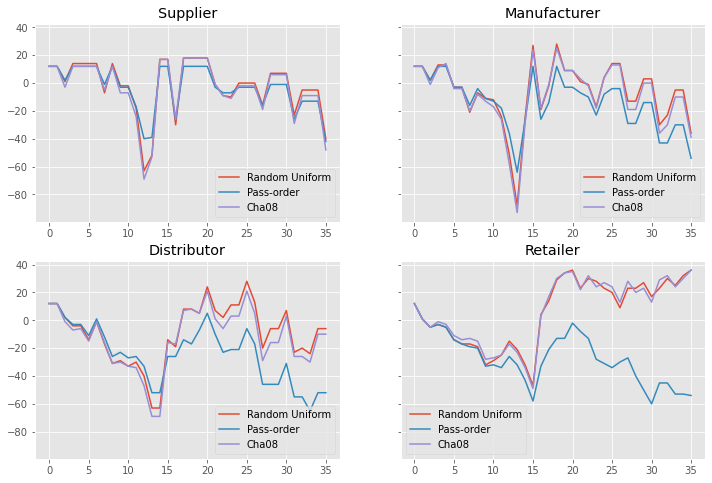

In [13]:
agents = ["Supplier", "Manufacturer", "Distributor", "Retailer"] 
fig, axes = plt.subplots(2,2, sharey=True, figsize=(12,8))
for ax, agent in zip(axes.reshape(-1), agents):
    ax.plot(dfru.T[agent]["inventory"], label="Random Uniform")
    ax.plot(dfpo.T[agent]["inventory"], label="Pass-order")
    ax.plot(dfcha.T[agent]["inventory"], label="Cha08")
    ax.set_title(agent)
    ax.legend()

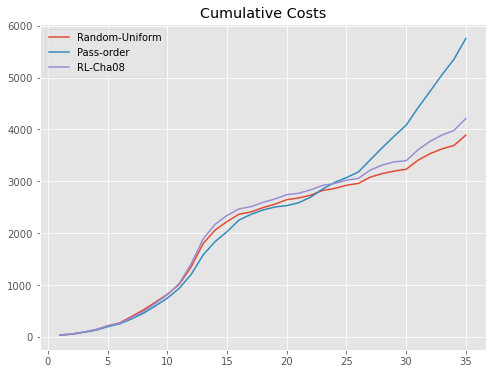

In [23]:
plt.figure(figsize=(8,6))
plt.plot(dfru.T.Cost.cumsum(), label="Random-Uniform")
plt.plot(dfpo.T.Cost.cumsum(), label="Pass-order")
plt.plot(dfcha.T.Cost.cumsum(), label="RL-Cha08")
plt.legend()
plt.title("Cumulative Costs");

### RL QL - Ours

Episode 2000/2000: Cost -3637.0 epsilon 0.10

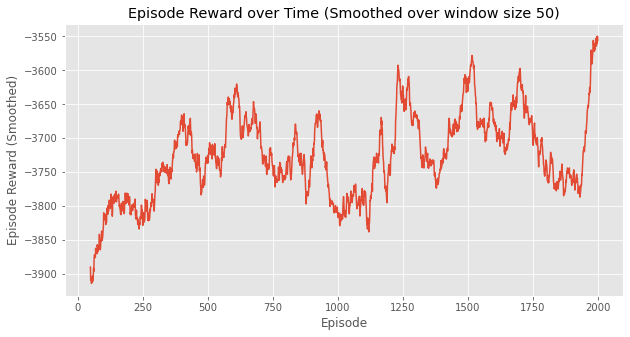

In [15]:
env = BeerGameEnv()
env.custom_init(data=data[MAIN])
Q, stats = q_learning(env, 2000, epsilon_range=(0.98,0.1), verbosity=2)
plotting.plot_rewards(stats, smoothing_window=50)

#### Determine actions from Q-Table

In [16]:
from ql import ql_get_policy
QL_POLICY = ql_get_policy(env, Q)

In [32]:
agent_names = ["Retailer", "Distributor","Manufacturer","Supplier", 'Source']
for i in range(1,6):
    print(f"{agent_names[i-1]}:\t {QL_POLICY[i][:10]}")

Retailer:	 [0, 3, 0, 0, 2, 3, 0, 3, 3, 3]
Distributor:	 [1, 2, 3, 3, 0, 2, 3, 0, 2, 0]
Manufacturer:	 [3, 1, 1, 1, 1, 0, 3, 1, 2, 1]
Supplier:	 [0, 2, 1, 1, 1, 2, 0, 0, 0, 0]
Source:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Simulate our QL

In [18]:
sc = SupplyChain(data=data[MAIN], policy=QL_POLICY)
dfql = sc.simultation_run()
dfql.T.Cost.sum()

cost    3716
dtype: object

Plot with our QL Implementation

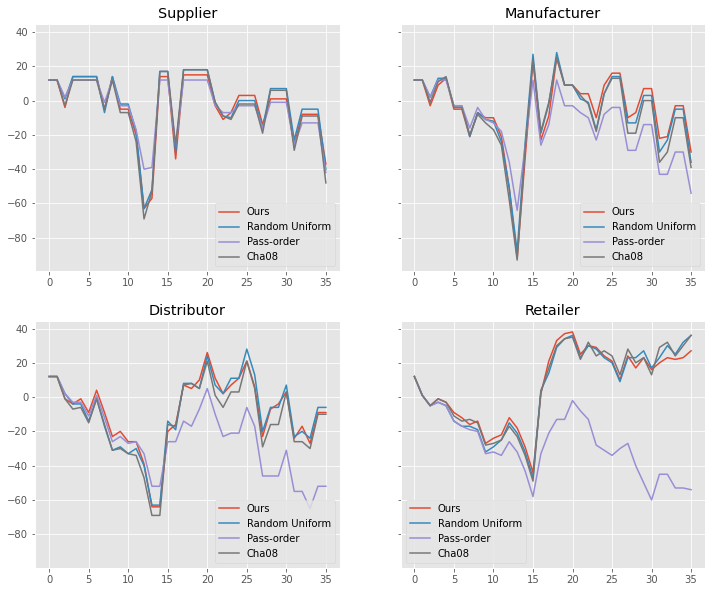

In [26]:
agents = ["Supplier", "Manufacturer", "Distributor", "Retailer"] 
fig, axes = plt.subplots(2,2, sharey=True, figsize=(12,10))

for ax, agent in zip(axes.reshape(-1), agents):
    ax.plot(dfql.T[agent]["inventory"], label="Ours")
    ax.plot(dfru.T[agent]["inventory"], label="Random Uniform")
    ax.plot(dfpo.T[agent]["inventory"], label="Pass-order")
    ax.plot(dfcha.T[agent]["inventory"], label="Cha08")
    ax.set_title(agent)
    ax.legend()

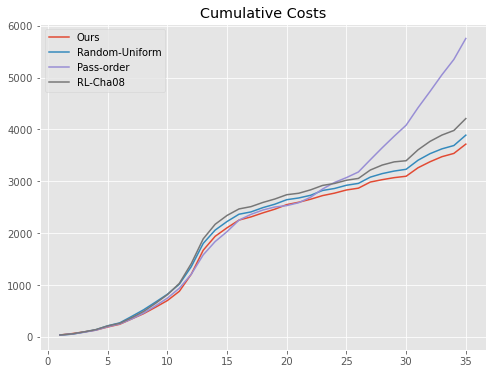

In [21]:
plt.figure(figsize=(8,6))
plt.plot(dfql.T.Cost.cumsum(), label="Ours")
plt.plot(dfru.T.Cost.cumsum(), label="Random-Uniform")
plt.plot(dfpo.T.Cost.cumsum(), label="Pass-order")
plt.plot(dfcha.T.Cost.cumsum(), label="RL-Cha08")
plt.legend()
plt.title("Cumulative Costs");